# Aula-05 Análise de Sentimentos usando Self-Attention
Nome: Thomás Portugal

In [0]:
import torch
import pandas as pd
import numpy as np
from torchtext.vocab import GloVe
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm_notebook
from math import ceil
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu" 
print(dev)
device = torch.device(dev)

cuda:0


# Preparando Dados

Primeiro, fazemos download do dataset:

In [0]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2020-04-08 01:38:03--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  1.81MB/s    in 0.3s    

2020-04-08 01:38:04 (1.81 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



Carregamos o dataset .csv usando o pandas:

In [0]:
df = pd.read_csv('imdb_sample/texts.csv')
df.shape
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Iremos agora dividir o dataset em conjuntos de treino e desenvolmento:

In [0]:
treino = df[df['is_valid'] == False]
valid = df[df['is_valid'] == True]

print('treino.shape:', treino.shape)
print('valid.shape:', valid.shape)

treino.shape: (800, 3)
valid.shape: (200, 3)


E iremos dividir estes dois conjuntos em entrada (X) e saída desejada (Y, ground-truth) do modelo:

In [0]:
X_treino = treino['text']
Y_treino = treino['label']
X_valid = valid['text']
Y_valid = valid['label']

print('X_treino.head():', X_treino.head())
print('Y_treino.head():', Y_treino.head())

X_treino.head(): 0    Un-bleeping-believable! Meg Ryan doesn't even ...
1    This is a extremely well-made film. The acting...
2    Every once in a long while a movie will come a...
3    Name just says it all. I watched this movie wi...
4    This movie succeeds at being one of the most u...
Name: text, dtype: object
Y_treino.head(): 0    negative
1    positive
2    negative
3    positive
4    negative
Name: label, dtype: object


Ainda falta converter as strings "positive" e "negative" do ground-truth para valores booleanos:

In [0]:
mapeamento = {'positive': True, 'negative': False}
Y_treino_bool = Y_treino.map(mapeamento)
Y_valid_bool = Y_valid.map(mapeamento)
print(Y_treino_bool.head())
Y_train = torch.tensor(Y_treino_bool.values, dtype = torch.float)
Y_test = torch.tensor(Y_valid_bool.values, dtype = torch.float)
Y_train.shape

0    False
1     True
2    False
3     True
4    False
Name: label, dtype: bool


torch.Size([800])

Convertendo os valores dos dados para numpy e os labels para tensores.{

In [0]:
X_train = X_treino.values
Y_train = torch.tensor(Y_treino_bool.values, dtype = torch.long)
X_test = X_valid.values
Y_test = torch.tensor(Y_valid_bool.values, dtype = torch.long)

# Carregando word embeddings com torchtext

In [0]:
# from torchtext.vocab import GloVe
glove_vectors = GloVe(name='6B', dim=300, cache='./glove_dir')

./glove_dir/glove.6B.zip: 862MB [06:46, 2.12MB/s]                           
100%|█████████▉| 399477/400000 [00:35<00:00, 11020.80it/s]

In [0]:

print(len(glove_vectors.stoi))
print(glove_vectors.vectors.shape)
print('Primeiras 20 palavras e seus índices:', list(glove_vectors.stoi.items())[-20:])

400000
torch.Size([400000, 300])
Primeiras 20 palavras e seus índices: [('whirlow', 399980), ('wanz', 399981), ('t22', 399982), ('slann', 399983), ('kunimoto', 399984), ('altares', 399985), ('cipolletti', 399986), ('sherwoods', 399987), ('sullana', 399988), ('29km', 399989), ('sigarms', 399990), ('katuna', 399991), ('aqm', 399992), ('1.3775', 399993), ('corythosaurus', 399994), ('chanty', 399995), ('kronik', 399996), ('rolonda', 399997), ('zsombor', 399998), ('sandberger', 399999)]


In [0]:
token_dict = glove_vectors.stoi
vectors_embedding = glove_vectors.vectors
tokenizer = CountVectorizer().build_tokenizer()

Incluindos o valor de padding no vocabulário e no vetor de embedding. 

In [0]:
pad_index = len(token_dict)
token_dict['<pad>'] = pad_index
padding_embedding = torch.rand(1,300)
vectors_embedding = torch.cat((vectors_embedding, padding_embedding))
vectors_embedding.shape

torch.Size([400001, 300])

In [0]:
token_dict['<pad>']

400000

In [0]:
torch.all(torch.eq(vectors_embedding[token_dict['<pad>']],padding_embedding))

tensor(True)

# Criando a classe de dataset
Na classe do dataset, insere-se as sentenças do conjunto de dados e seus respectivos dados. Ao inicializar, ela trunca as sentenças no tamanho desejado, realiza o padding e armazena os valores dos vetores embedding de cada sentença (e suas respectivas labels).


In [0]:
class IMDBAttentionDataset(Dataset):
  def __init__(self, data,Y, sentence_size):
    corpus_embedding = []
    for sentence in data:
      sentence = tokenizer(sentence)
      if len(sentence)<sentence_size:
        pad_sequence = ((sentence_size-len(sentence))*'<pad> ').strip().split(' ')
        sentence.extend(pad_sequence)
      else:
        sentence = sentence[:sentence_size]
      try:
        sentence_embedding = torch.stack([vectors_embedding[token_dict[word.lower()]]for word in sentence])
      except KeyError as e:
        sentence_embedding = torch.stack([vectors_embedding[token_dict[word.lower()]] if word.lower() in token_dict.keys() else vectors_embedding[token_dict['<pad>']] for word in sentence])
        # torch.eq(sentence_embedding,)
      corpus_embedding.append(sentence_embedding)
    corpus_embedding = torch.stack(corpus_embedding)
    self.data_embeddings = corpus_embedding
    self.label = Y

  def __len__(self):
    return len(self.data_embeddings)

  def __getitem__(self, idx):
    return (self.data_embeddings[idx],self.label[idx])


In [0]:
#Declaração do dataset
sentence_size = 1000
imdb_dataset_train = IMDBAttentionDataset(X_train,Y_train,sentence_size)
imdb_dataset_test = IMDBAttentionDataset(X_test,Y_test,sentence_size)
Data_IMDB = DataLoader(imdb_dataset_test,batch_size = 50, shuffle=True)
for batch_x, batch_y in Data_IMDB:
  print(batch_x.shape,batch_y.shape)


torch.Size([50, 1000, 300]) torch.Size([50])
torch.Size([50, 1000, 300]) torch.Size([50])
torch.Size([50, 1000, 300]) torch.Size([50])
torch.Size([50, 1000, 300]) torch.Size([50])


In [0]:
padding_embedding.view(-1).shape

torch.Size([300])

# Criando modelo da rede

In [0]:
def SelfAttention(embeddings, type = 'fast'):
  index_pads= torch.all(torch.eq(embeddings, padding_embedding.to(device)),dim = 2)  #Matriz booleana pada identificar os pads em cada amostra.
  if type == 'fast':
    
    keys = embeddings
    query = embeddings.permute(0,2,1) 
    scores = torch.matmul(keys,query)
    scores[index_pads,:] = torch.tensor(-9999, dtype = torch.float).to(device)
    scores = scores.permute(0,1,2)     #Corrigindo a orientação correta dos valores de PAD. Aproveita-se que a matriz é simétrica
    probs = torch.nn.functional.softmax(scores, dim=-1)
    embeddings_output = torch.matmul(probs,keys)
  
  elif type=='slow':
    
    embeddings_output = []
    for sentence in embeddings:
      new_embeddings = []
      for key in sentence:
        if not torch.all(torch.eq(key, padding_embedding.to(device))):
          scores = []
          for query in sentence:
            if not torch.all(torch.eq(query, padding_embedding.to(device))):
              scores.append(torch.dot(key,query))
            else:
              scores.append(torch.tensor(-9999, dtype = torch.float).to(device))
          scores = torch.stack(scores)
          probs = torch.nn.functional.softmax(scores)
          # print(key.shape)
          new_embedding = torch.zeros([key.shape[0]], dtype=torch.float).to(device)
          for v, prob  in zip(sentence,probs):
            new_embedding += v*prob
        else:
          new_embedding = padding_embedding.view(-1).to(device)
        new_embeddings.append(new_embedding)
        
      embeddings_output.append(torch.stack(new_embeddings))
    embeddings_output = torch.stack(embeddings_output)

  else:
    print("Error Self Attention mode")
    return -1
  
  return index_pads, embeddings_output

class ModelSelfAttention(torch.nn.Module):
  def __init__(self, hidden_size = 1000, embedding_dim = 300):
    super(ModelSelfAttention,self).__init__()
    self.layer1 = torch.nn.Linear(in_features = embedding_dim , out_features=hidden_size)
    self.activation = torch.nn.ReLU()
    self.layer2 = torch.nn.Linear(in_features = hidden_size, out_features = 2)

  def forward(self, x):
    index_pads, new_embeddings = SelfAttention(x)
    # print(new_embeddings.shape)
    new_embeddings[index_pads,:] = 0
    mask = ~index_pads
    mean_embeddings = new_embeddings.sum(dim=1)/mask.sum(dim=1).view(-1,1) #inspirado por https://discuss.pytorch.org/t/how-to-do-masked-mean-while-reserving-the-first-dimension/35496/3
    h = self.layer1(mean_embeddings)
    h = self.activation(h)
    o = self.layer2(h)

    return o




Testando a função de self attention e o modelo

In [0]:
model_att = ModelSelfAttention()
model_att = model_att.to(device)
for batch_x, batch_y in Data_IMDB:
  index_pad, batch_x_att = SelfAttention(batch_x.to(device), type='slow')
  out = model_att(batch_x.to(device))
  print(batch_x_att.shape)
  print(out.shape)
  break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([50, 100, 300])
torch.Size([50, 2])


In [0]:
model_att = ModelSelfAttention()
model_att = model_att.to(device)
for batch_x, batch_y in Data_IMDB:
  index_pad, batch_x_att = SelfAttention(batch_x.to(device), type='fast')
  out = model_att(batch_x.to(device))
  print(batch_x_att.shape)
  print(out.shape)
  break

torch.Size([50, 100, 300])
torch.Size([50, 2])


In [0]:
def train(IMDB_dataset, batch_size, model, n_epochs, optimizer, loss_function = torch.nn.CrossEntropyLoss(), validate = False, data_val = None):
  train_loss_list = []
  
  progress = tqdm_notebook(total=n_epochs)
  model = model.to(device)
  Data_IMDB = DataLoader(IMDB_dataset,batch_size = batch_size, shuffle=True)

  for epoch in range(n_epochs):
    model.train()
    running_loss= 0.0
    for batch_X, batch_Y in Data_IMDB:
      batch_X = batch_X.to(device)
      batch_Y = batch_Y.to(device)
      y_logits = model(batch_X)
      loss = loss_function(y_logits,batch_Y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      running_loss += loss.item()
    progress.update(1)
    train_loss_list.append(running_loss/len(Data_IMDB))
    
  return train_loss_list

def test(IMDB_dataset, model, batch_size, loss_function=torch.nn.CrossEntropyLoss()):
  Data_IMDB = DataLoader(IMDB_dataset,batch_size = batch_size, shuffle=True)
  running_loss = 0
  sum_correct = 0
  model.eval()
  with torch.no_grad():
    for batch_X, batch_Y in Data_IMDB:
      batch_X = batch_X.to(device)
      batch_Y = batch_Y.to(device)
      y_logits = model(batch_X)
      loss = loss_function(y_logits,batch_Y)
      running_loss += loss.item()
      y_prob = torch.nn.functional.log_softmax(y_logits)
      y_pred = y_prob.argmax(dim=1)
      sum_correct = torch.eq(batch_Y,y_pred).sum().item()
      # print("Running Loss Test: {}".format(running_loss))
    test_loss = running_loss/len(batch_X)
    acc = sum_correct/len(batch_Y)
    
    print("Loss: {:.4f} Accuracy: {:.4f}".format(test_loss, acc))
  return test_loss, acc


In [0]:
batch_size = 400
n_epochs = 1000
model_self_attention = ModelSelfAttention(hidden_size=100)
optimizer = torch.optim.SGD(model_self_attention.parameters(), lr = 0.1)
train_loss_list = train(imdb_dataset_train,batch_size,model_self_attention,n_epochs,optimizer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'N_epochs x Loss - Train Set')

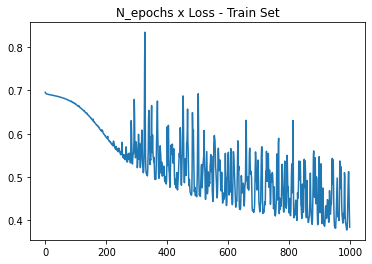

In [0]:
plt.plot(train_loss_list)
plt.title("N_epochs x Loss - Train Set")

In [0]:
loss_test, acc = test(imdb_dataset_test,model_self_attention,batch_size =200)

Loss: 0.0023 Accuracy: 0.8200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Medindo o tempo

In [0]:
batch_size = 100
n_epochs = 100
hidden_size = 1000
model_self_attention = ModelSelfAttention(hidden_size = hidden_size)
optimizer = torch.optim.SGD(model_self_attention.parameters(), lr = 0.1)
start = time()
train_loss_list = train(imdb_dataset_train,batch_size,model_self_attention,n_epochs,optimizer)
end = time()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [0]:
print("Time Elapsed: {}".format(end-start))
print("{} seconds per example".format((end-start)/((len(imdb_dataset_train)*n_epochs))))

Time Elapsed: 90.64946818351746
0.001133118352293968 seconds per example


In [0]:
start_fast = time()
for batch_x, batch_y in Data_IMDB:
  index_pad, batch_x_att = SelfAttention(batch_x.to(device), type='fast')
  print(batch_x_att.shape)
  break
end_fast = time()

torch.Size([50, 1000, 300])


In [0]:
start_slow = time()

for batch_x, batch_y in Data_IMDB:
  index_pad, batch_x_att = SelfAttention(batch_x.to(device), type='slow')
  print(batch_x_att.shape)
  break

end_slow = time()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([50, 1000, 300])


In [0]:
print("Slow Method: {} seconds to process 1 sample".format((end_fast-start_fast)/len(batch_x)))
print("Fast Method: {} seconds to process 1 sample".format((end_slow-start_slow)/len(batch_x)))

Slow Method: 0.0009058523178100586 seconds to process 1 sample
Fast Method: 27.810312495231628 seconds to process 1 sample
